## Stable Diffusion (Text to Image)

#### I. Imports 

In [ ]:
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models 
#The `list_jumpstart_models()` function returns a list of all the models that are available in the current SageMaker region.
from sagemaker.utils import name_from_base
# The `name_from_base()` function takes a base name and returns the full name of the model.
from sagemaker.predictor import Predictor
#The `Predictor` class represents a model that can be used to make predictions.
from sagemaker import get_execution_role
#The `get_execution_role()` function returns the execution role that is required to use the model.
from sagemaker.model import Model
#The `Model` class represents a model that can be trained and deployed on Amazon SageMaker.
from sagemaker import script_uris
#The `script_uris()` function returns a list of script URLs that can be used to train the model.
from sagemaker import image_uris
#The `image_uris()` function returns a list of image URLs that can be used to deploy the model.
from sagemaker import model_uris
#The `model_uris()` function returns a list of model URLs that can be used to access the model.
import matplotlib.pyplot as plt
import numpy as np
import sagemaker
import datetime
import logging
import boto3
import json

##### Setup logging 

In [ ]:
#This code creates a logger object with the name "sagemaker". The logger's level is set to DEBUG, which means that all messages will be logged. The logger's handler is a StreamHandler, which means that the messages will be logged to the console.
logger = logging.getLogger('sagemaker')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

##### Log versions of dependencies 

In [ ]:
logger.info(f'[Using sagemaker version: {sagemaker.__version__}]')
logger.info(f'[Using boto3 version: {sagemaker.__version__}]')

#### II. Setup essentials 

In [ ]:
ROLE = get_execution_role()
REGION = boto3.Session().region_name
session = sagemaker.Session()
logger.info(f'Region: {REGION}')

##### List all models from SageMaker JumpStart hub

In [ ]:
FILTER = 'task == txt2img'
txt2img_models = list_jumpstart_models(filter=FILTER)
txt2img_models

In [ ]:
MODEL_ID = 'model-txt2img-stabilityai-stable-diffusion-v2-1-base'
MODEL_VERSION = '*'  # latest
SCOPE = 'inference'
INFERENCE_INSTANCE_TYPE = 'ml.p3.2xlarge'  # prefered EC2 instance type

#### III. Retrieve inference artifacts 

In [ ]:
inference_image_uri = image_uris.retrieve(region=REGION, 
                                          framework=None,
                                          model_id=MODEL_ID, 
                                          model_version=MODEL_VERSION, 
                                          image_scope=SCOPE, 
                                          instance_type=INFERENCE_INSTANCE_TYPE)
logger.info(f'Inference image URI: {inference_image_uri}')

In [ ]:
inference_source_uri = script_uris.retrieve(model_id=MODEL_ID, 
                                            model_version=MODEL_VERSION, 
                                            script_scope=SCOPE)
logger.info(f'Inference source URI: {inference_source_uri}')

In [ ]:
inference_model_uri = model_uris.retrieve(model_id=MODEL_ID, 
                                          model_version=MODEL_VERSION, 
                                          model_scope=SCOPE)
logger.info(f'Inference model URI: {inference_model_uri}')

In [ ]:
# To increase the maximum response size from the endpoint
env = {'MMS_MAX_RESPONSE_SIZE': '20000000'}

In [ ]:
current_time = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
endpoint_name = f'tescal2-sd-{current_time}'
logger.info(f'Endpoint name = {endpoint_name}')

In [ ]:
model = Model(image_uri=inference_image_uri,
              source_dir=inference_source_uri,
              model_data=inference_model_uri,
              entry_point='inference.py',  
              role=ROLE,
              predictor_cls=Predictor,
              name=endpoint_name,
              env=env)

#### IV. Deploy Stable Diffusion model as a SageMaker endpoint

Takes around 11 to 14 mins

In [ ]:
%%time

_ = model.deploy(initial_instance_count=1, 
                 instance_type=INFERENCE_INSTANCE_TYPE, 
                 predictor_cls=Predictor, 
                 endpoint_name=endpoint_name)

#### V. Invoke the endpoint for inference 

In [ ]:
client = boto3.client('sagemaker-runtime')

In [ ]:
prompt = """a futuristic nike shoe with rocket boosters for levitation, high quality, highly detailed, sharp focus, unreal engine, bright indoor lighting, detailed architecture, hyper realistic, octane render, 4k HD"""

* **`num_images_per_prompt`**: The num_images_per_prompt is the number of images that you want to generate for each prompt. It can be any positive integer value.
* **`num_inference_steps`**: The num_inference_steps is the number of steps that the image generator will take to create an image. It can be any positive integer value, but higher values may take longer time and consume more resources.
* **`guidance_scale`**: The guidance_scale is a parameter that controls how much the image generator will follow the prompt. It can be any positive decimal value, but higher values may result in more realistic images that match the prompt.

In [ ]:
payload = {'prompt': prompt,
           'num_images_per_prompt': 1, 
           'num_inference_steps': 50, 
           'guidance_scale': 7.5
          }

In [ ]:
payload = json.dumps(payload).encode('utf-8')

In [ ]:
%%time

response = client.invoke_endpoint(EndpointName=endpoint_name, 
                                  Body=payload, 
                                  ContentType='application/x-text')

response_body = json.loads(response['Body'].read().decode())
generated_image = response_body['generated_image']

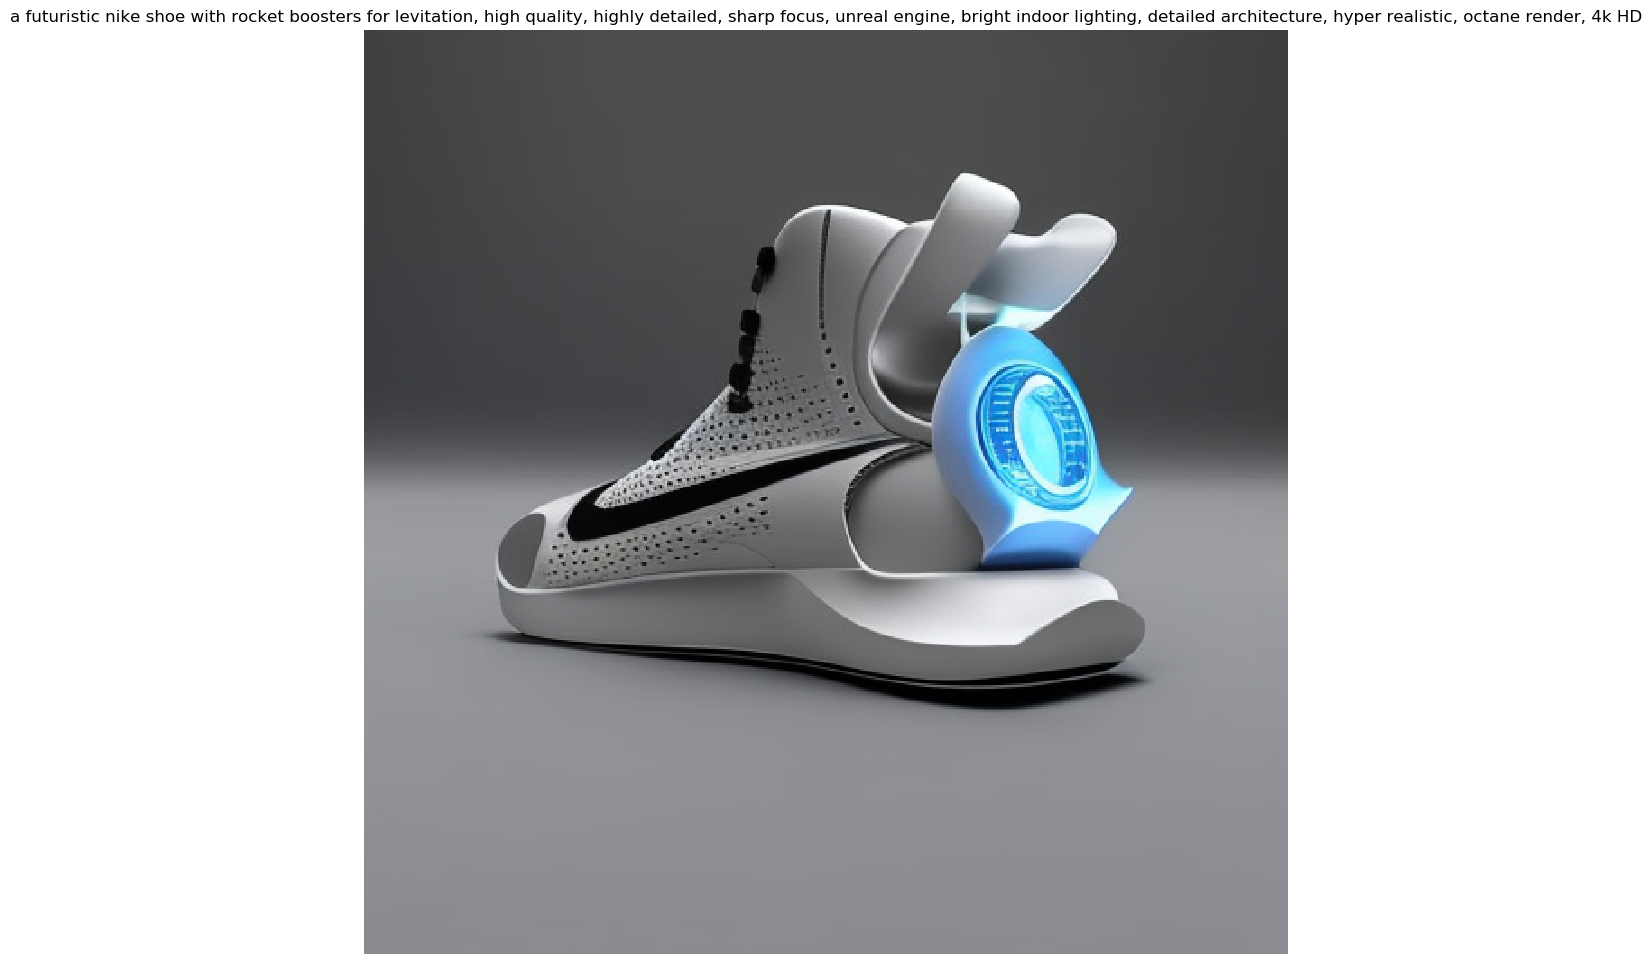

In [39]:
plt.figure(figsize=(12, 12))
plt.imshow(np.array(generated_image))
plt.axis('off')
plt.title(prompt)
plt.show()

In [ ]:
# Delete endpoint to save costs
predictor.delete_endpoint()